In [8]:
import numpy as np
from ripser import ripser
import matplotlib.pyplot as plt
from simulator_pa import pa_generator
import betti
import pandas as pd

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.optimize import curve_fit



# Speed
- Run as scripts
- Compare graph generation time vs Betti # (numba may help)
- joblib to run in parallel

# Graphs
- CDF (Right to Left) 
- Plot all graphs on same plot
- Check if Log-Log CDF is roughly linear
- Fit line to Log-Log CDF

In [9]:
def emp_cdf(x):
    n = len(x)
    x_sort = np.sort(x)
    cdf = (np.arange(1, n + 1) - 0.5) / n
    cdf = cdf[::-1]
    return x_sort, cdf


N = 1000


def betti_nums(num_nodes, m, delta):
    betti_nums = np.zeros((N, num_nodes))
    betti_vals = np.zeros(N)
    for i in range(N):
        graph = pa_generator(num_nodes, m, delta, i)
        mat = betti.get_age_matrix(graph) # obtain the age matrix of the complex as an input for ripser
        dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms'] # get the persistence diagrams
        betti2_actual = betti.translate_PD_to_betti(dgms[2], num_nodes) # read the betti numbers from persistence diagrams
        betti_vals[i] = betti2_actual[-1]
        betti_nums[i] = betti2_actual
        
#     mean = np.mean(betti_vals)
#     halfwidth = 1.96 * np.std(betti_vals) / np.sqrt(N)
#     CI = f'[{mean - halfwidth}, {mean + halfwidth}]'
#     data = {'Num Nodes' : num_nodes, 'm' : m, 'delta' : delta, 'CI' : CI}

    x, cdf = emp_cdf(betti_vals)
    return x, cdf, betti_nums



In [10]:
args = [(10000, j, -i * j / 10) for i in range(1, 10, 2) for j in [10, 8]]
args

[(10000, 10, -1.0),
 (10000, 8, -0.8),
 (10000, 10, -3.0),
 (10000, 8, -2.4),
 (10000, 10, -5.0),
 (10000, 8, -4.0),
 (10000, 10, -7.0),
 (10000, 8, -5.6),
 (10000, 10, -9.0),
 (10000, 8, -7.2)]

In [11]:
x, cdf, betti_nums = zip(*Parallel(n_jobs=-1)(delayed(betti_nums)(*arg) for arg in args))

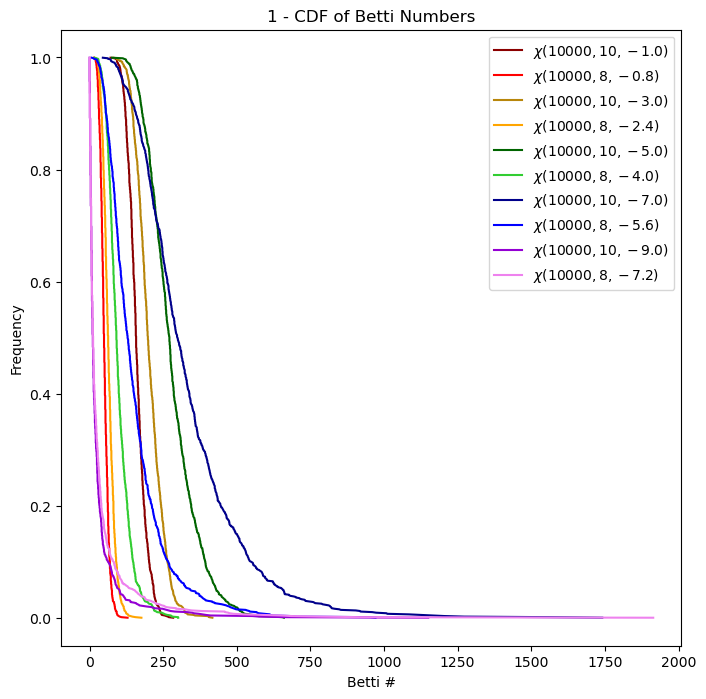

In [58]:
plt.figure(figsize=(8, 8))

colors = ['darkred', 'red', 'darkgoldenrod', 'orange', 'darkgreen', 'limegreen', 'darkblue', 'blue', 'darkviolet', 'violet']

for i in range(len(x)):
    plt.plot(x[i], cdf[i], color = colors[i], label = f'$\chi{args[i]}$')

plt.xlabel('Betti #')
plt.ylabel('Frequency')
plt.legend()
plt.title(r'1 - CDF of Betti Numbers')
plt.show()

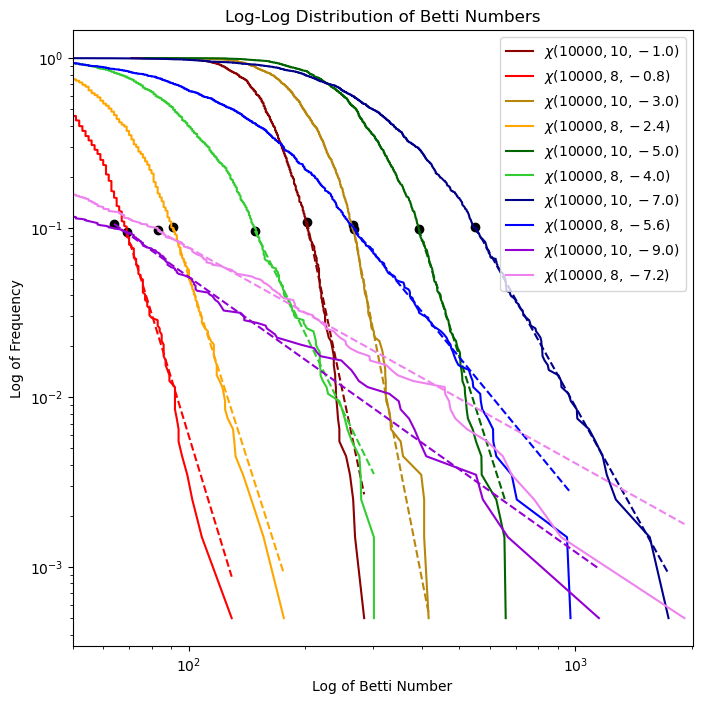

In [59]:
def powerlaw(x, a, b):
    return a * x**b

curve = powerlaw
cols = list(curve.__code__.co_varnames)[1:]
df = pd.DataFrame(columns = cols)

plt.figure(figsize=(8,8))

threshold = 900 # fit line to data after this point

for i in range(len(x)):
    plt.plot(x[i], cdf[i], color = colors[i], label = f'$\chi{args[i]}$')
    popt, _ = curve_fit(curve, x[i][threshold:], cdf[i][threshold:], maxfev = 10000)
    data = {cols[i] : popt[i] for i in range(len(popt))}
    data.update({'m' : args[i][1], 'delta' : args[i][2], 'var/mean' : np.var(x[i]) / np.mean(x[i]), 'delta/m' : args[i][2] / args[i][1], 'color' : colors[i]})
    df = pd.concat([df, pd.DataFrame([data])], ignore_index = True)
    plt.plot(x[i][threshold:], curve(x[i][threshold:], *popt), '--', color = colors[i])
    plt.scatter(x[i][threshold], curve(x[i][threshold], *popt), color = 'black')
    #     a, b = np.polyfit(xlog[i], cdflog[i], 1)
#     plt.plot(x[i], a * x[i] + b, linestyle='--', linewidth=2, label = f'Best fit for $\chi{args[i]}$')
    
plt.xlabel('Log of Betti Number')
plt.ylabel('Log of Frequency')
plt.xlim(50)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r'Log-Log Distribution of Betti Numbers')
plt.show()


In [55]:
df

,a,b,m,delta,var/mean,delta/m,color
0,1.182519e+24,-10.860498,10.0,-1.0,6.142297,-0.1,darkred
1,5.354511e+12,-7.479249,8.0,-0.8,4.219723,-0.1,red
2,1.515047e+27,-11.622649,10.0,-3.0,10.882796,-0.3,darkorange
3,9.026383e+12,-7.122411,8.0,-2.4,6.354740,-0.3,orange
4,3.680151e+17,-7.158354,10.0,-5.0,25.527969,-0.5,darkgreen
5,1.203599e+09,-4.652857,8.0,-4.0,16.639720,-0.5,green
6,1.593462e+10,-4.085813,10.0,-7.0,96.622566,-0.7,darkblue
7,5.165062e+05,-2.769572,8.0,-5.6,71.958413,-0.7,blue
8,8.900665e+01,-1.620218,10.0,-9.0,153.378616,-0.9,darkviolet
9,2.639339e+01,-1.269989,8.0,-7.2,256.792774,-0.9,violet


[Text(0.5, 1.0, 'Power Law Exponent $b$ by Ratio $\\frac{\\delta}{m}$'),
 Text(0.5, 0, '$\\frac{\\delta}{m}$'),
 Text(0, 0.5, '$b$')]

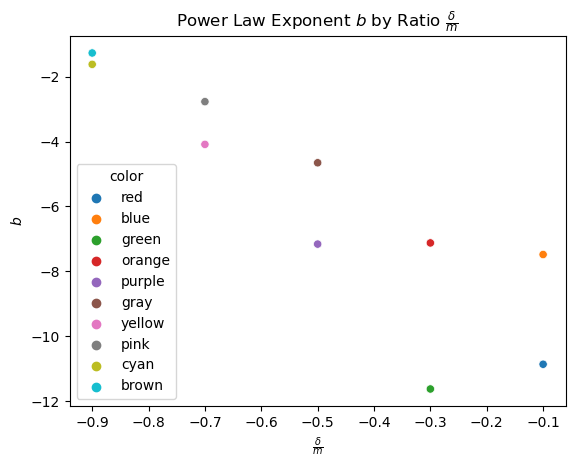

In [15]:
import seaborn as sns

sns.scatterplot(data = df, x = 'delta/m', y = 'b', hue = 'color', legend = True).set(title = r'Power Law Exponent $b$ by Ratio $\frac{\delta}{m}$', xlabel = r'$\frac{\delta}{m}$', ylabel = r'$b$')

In [16]:
df

,a,b,m,delta,var/mean,delta/m,color
0,1.182519e+24,-10.860498,10.0,-1.0,6.142297,-0.1,red
1,5.354511e+12,-7.479249,8.0,-0.8,4.219723,-0.1,blue
2,1.515047e+27,-11.622649,10.0,-3.0,10.882796,-0.3,green
3,9.026383e+12,-7.122411,8.0,-2.4,6.354740,-0.3,orange
4,3.680151e+17,-7.158354,10.0,-5.0,25.527969,-0.5,purple
5,1.203599e+09,-4.652857,8.0,-4.0,16.639720,-0.5,gray
6,1.593462e+10,-4.085813,10.0,-7.0,96.622566,-0.7,yellow
7,5.165062e+05,-2.769572,8.0,-5.6,71.958413,-0.7,pink
8,8.900665e+01,-1.620218,10.0,-9.0,153.378616,-0.9,cyan
9,2.639339e+01,-1.269989,8.0,-7.2,256.792774,-0.9,brown


In [17]:
np.save('x', x)
np.save('cdf', cdf)
np.save('betti_nums', betti_nums)

In [18]:
data = np.load('betti_nums.npy')
data

array([[[  0.,   0.,   0., ..., 208., 208., 208.],
        [  0.,   0.,   0., ..., 152., 152., 152.],
        [  0.,   0.,   0., ..., 167., 167., 167.],
        ...,
        [  0.,   0.,   0., ..., 168., 168., 168.],
        [  0.,   0.,   0., ..., 170., 170., 170.],
        [  0.,   0.,   0., ..., 150., 150., 150.]],

       [[  0.,   0.,   0., ...,  94.,  94.,  94.],
        [  0.,   0.,   0., ...,  41.,  41.,  41.],
        [  0.,   0.,   0., ...,  52.,  52.,  52.],
        ...,
        [  0.,   0.,   0., ...,  67.,  67.,  67.],
        [  0.,   0.,   0., ...,  63.,  63.,  63.],
        [  0.,   0.,   0., ...,  37.,  37.,  37.]],

       [[  0.,   0.,   0., ..., 269., 269., 269.],
        [  0.,   0.,   0., ..., 186., 186., 186.],
        [  0.,   0.,   0., ..., 145., 145., 145.],
        ...,
        [  0.,   0.,   0., ..., 206., 206., 206.],
        [  0.,   0.,   0., ..., 235., 235., 235.],
        [  0.,   0.,   0., ..., 177., 177., 177.]],

       ...,

       [[  0.,   0.,   0

In [39]:
shape = data.shape
mean = np.zeros((shape[0], shape[2]))
var = np.zeros((shape[0], shape[2]))
for j in range(shape[0]):    
    arr1 = np.zeros(shape[2])
    for i in data[j]:
        arr1 += i
    arr1 = arr1 / shape[1]
    arr2 = np.zeros(shape[2])
    arr3 = np.zeros(shape[2])
    for i in range(shape[2]):
        arr2[i] = np.mean(arr1[0:i+1])
        arr3[i] = np.var(arr1[0:i+1])
    mean[j] = arr2
    var[j] = arr3
ratio = var / mean
ratio

/var/folders/qv/s764zmy112sc2bnmdh6fm3hw0000gn/T/ipykernel_51955/51032825.py:16: RuntimeWarning: invalid value encountered in divide
  ratio = var / mean


array([[        nan,         nan,         nan, ...,  3.53708734,
         3.53681326,  3.53653924],
       [        nan,         nan,         nan, ...,  0.69732148,
         0.69726344,  0.6972054 ],
       [        nan,         nan,         nan, ...,  7.47102784,
         7.47059659,  7.47016537],
       ...,
       [        nan,         nan,         nan, ..., 16.8789484 ,
        16.87941243, 16.87987598],
       [        nan,         nan,         nan, ...,  5.86683152,
         5.86752997,  5.86822789],
       [        nan,         nan,         nan, ...,  7.03793927,
         7.03869143,  7.03944376]])

In [25]:
mean = np.zeros(x.shape)
var = np.zeros(x.shape)
for i in range(len(x)):
    for j in range(len(x[i])):
        mean[i, j] = np.mean(x[i, 0:j+1])
        var[i, j] = np.var(x[i, 0:j+1])
ratio = var / mean

/var/folders/qv/s764zmy112sc2bnmdh6fm3hw0000gn/T/ipykernel_51986/3863025301.py:7: RuntimeWarning: invalid value encountered in divide
  ratio = var / mean


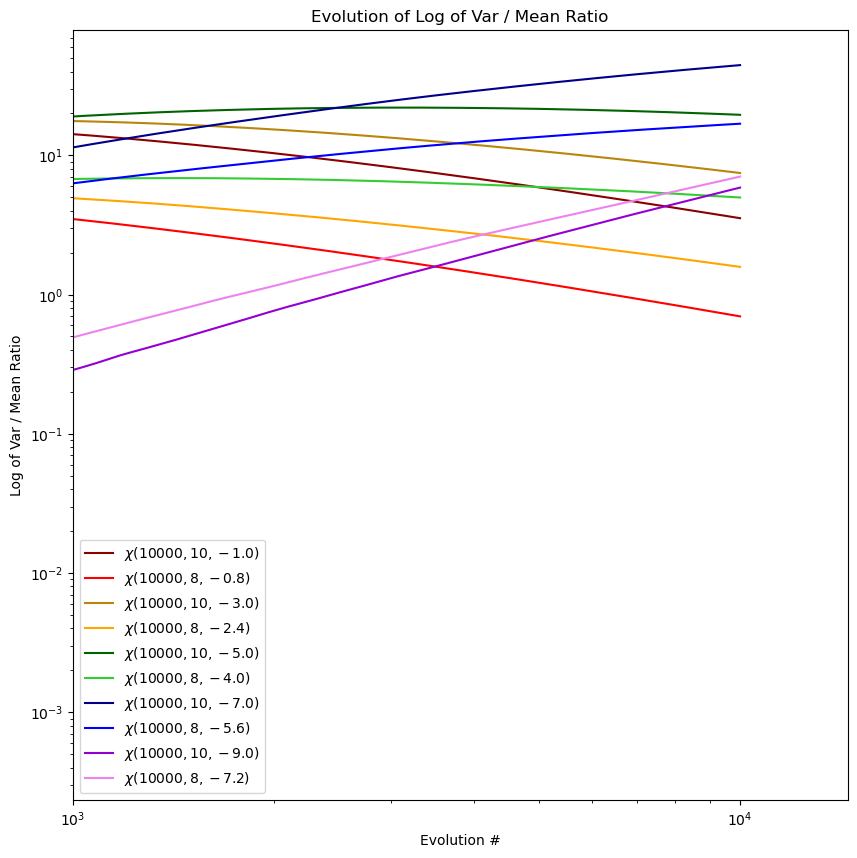

In [84]:
plt.figure(figsize=(10,10))
for i in range(len(x)):
    plt.loglog(np.arange(10000), ratio[i], color = colors[i], label = f'$\chi{args[i]}$')
    plt.xlim(1000)
#     plt.ylim(1/10)
#     plt.gca().set_aspect('equal')
    plt.legend()
    plt.xlabel(f'Evolution #')
    plt.ylabel(f'Log of Var / Mean Ratio')
    plt.title(f'Evolution of Log of Var / Mean Ratio')

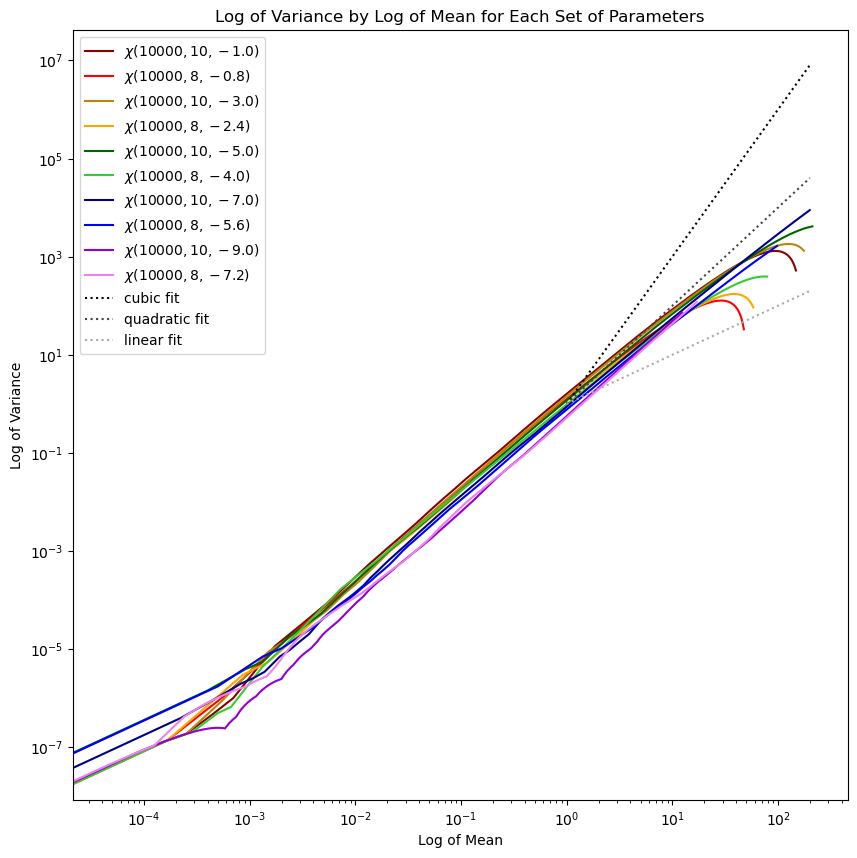

In [74]:
plt.figure(figsize=(10,10))

for i in range(shape[0]):
    plt.plot(mean[i], var[i], color = colors[i], label = f'$\chi{args[i]}$')
    plt.xscale('log')
    plt.yscale('log')
plt.plot(np.arange(200) + 1, (np.arange(200) + 1)**3, color = 'black', label = 'cubic fit', linestyle = ':')
plt.plot(np.arange(200) + 1, (np.arange(200) + 1)**2, color = '#444444', label = 'quadratic fit', linestyle = ':')
plt.plot(np.arange(200) + 1, (np.arange(200) + 1), color = '#AAAAAA', label = 'linear fit',linestyle = ':')
plt.title(f'Log of Variance by Log of Mean for Each Set of Parameters')
plt.ylabel(f'Log of Variance')
plt.xlabel(f'Log of Mean')
plt.legend()
plt.show()




Distribution of the Upper Bounds on the Betti Numbers